In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import seaborn as sns

Pour simuler la gestion de nos deux populations, ING et PREPA, plusieurs choix ont dû être faits :
- génération : Nous avons décidé de gérer la génération et les temps d'arrivée de nos deux populations séparément, puis de les merge dans un dataframe global, en les ordonnant par temps d'arrivée. Leurs autre paramètres, tels que leur temps de service et de séjour, sont générés par la suite. Les deux population étant été générées séparément, cela a forcé un dédoublement des variables qui leurs sont propres, comme le taux d'arrivée et de séjour.
- proportion : Dans notre simulation, il y a autant d'ING que de PREPA, ce qui correspond globalement à la réalité (ING étant supposé avoir des pushs bien plus fréquent que PREPA, nous avons considéré que ING devait représenter ING1 seulement)
- temps d'arrivée : Pour avoir la possibilité d'observer une vraie différence entre nos population, tout en essayant de nous rapprocher de la réalité, nous avons considéré que les pushs des ING arrivaient 2 fois plus souvent que les pushs des PREPA.
- temps de séjour : De la même façon, nous avons considéré que les pushs des ING occupent les serveurs 2 fois moins longtemps que les pushs des PREPA.

In [57]:
class mmk_finite_two_populations():
    """
    Classe représentant un système de file M/M/K avec une taille de file finie, pour deux populations (ING, PREPA).

    Attributs:
        lamda_ing (float): Taux d'arrivée de la population ING
        lamda_prepa (float): Taux d'arrivée de la population PREPA
        mu_ing (float): Taux de service de la population ING
        mu_prepa (float): Taux de service de la population PREPA
        k (int): Nombre de serveurs
        Ks (int): Taille maximum de la file (SANS compter les serveurs)
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        refused_pushes_ing (int): Pushes refusés pour la population ING
        refused_pushes_prepa (int): Pushes refusés pour la population PREPA
        tops (pd.DataFrame): données de timing pour chaque push
    """
    
    def __init__(self, lamda_ing, lamda_prepa, mu_ing, mu_prepa, k, Ks, gen, test_z=100):
        """
        Initialisation du système de file M/M/K avec une taille de file finie pour deux populations.

        Args:
            lamda_ing: Taux d'arrivée de la population ING
            lamda_prepa: Taux d'arrivée de la population PREPA
            mu_ing: Taux de service de la population ING
            mu_prepa: Taux de service de la population PREPA
            k: Nombre de serveurs
            Ks: Taille maximum de la file (SANS compter les serveurs)
            gen: Générateur de nombre random
            test_z: Nombre de pushes à simuler
        """
        # Paramètres de la file
        self.lamda_ing = lamda_ing
        self.lamda_prepa = lamda_prepa
        self.mu_ing = mu_ing
        self.mu_prepa = mu_prepa
        self.k = k
        self.Ks = Ks
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes_ing = 0
        self.refused_pushes_prepa = 0
        
        # Initialisation du Dataframe temporel
        self.tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure', 'population'],
            data=np.zeros((test_z, 4))
        )
        
    def run(self):
        """
        Simule le système de file M/M/K avec une taille finie pour deux populations.
        """
        print("Lancement de la simulation M/M/K pour deux populations")
        
        # Ajout des colonnes temporelles
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)

        # Ajout de la colonne pour traquer le nombre de rejet
        self.tops["rejected"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Gènère les temps d'arrivée pour les deux population
        arrivals_ing = np.cumsum(self.gen.exponential(1 / self.lamda_ing, self.t_size // 2))
        arrivals_prepa = np.cumsum(self.gen.exponential(1 / self.lamda_prepa, self.t_size // 2))
        
        # Merge et tri des temps d'arrivée + ajout des labels de population
        arrivals = np.concatenate((arrivals_ing, arrivals_prepa))
        populations = ['ING'] * len(arrivals_ing) + ['PREPA'] * len(arrivals_prepa)
        combined = sorted(zip(arrivals, populations))
        
        # Traitement des pushs
        for i, (arrival_time, population) in enumerate(combined):
            self.tops.loc[i, "t_arrival"] = arrival_time
            self.tops.loc[i, "population"] = population
            
            # Compte les pushs actuellement dans la file
            current_time = arrival_time
            in_queue = ((self.tops["t_arrival"] <= current_time) & 
                       (self.tops["t_service_start"] > current_time)).sum()
            
            # Vérifie si la limite de taille de la file d'attente est atteinte
            if in_queue >= self.Ks:
                if population == 'ING':
                    self.refused_pushes_ing += 1
                else:
                    self.refused_pushes_prepa += 1
                self.tops.loc[i, "rejected"] = 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le début du temps de service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], arrival_time)
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - arrival_time
            if population == 'ING':
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_ing)
            else:
                self.tops.loc[i, "t_service"] = self.gen.exponential(1 / self.mu_prepa)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]

    def counts(self, t_intervals, population= "BOTH"):
        """
        Calcule le nombre de push dans le système à des intervalles de temps régulier
        
        Args:
            t_intervals: L'intervalle de temps pour les mesures
            population: Le type de population étudiée (BOTH pour les deux, PREPA ou ING pour l'étude d'une population en particulier)
            
        Returns:
            Dataframe avec le nombre de push dans le système, dans la file d'attente, en service et rejeté
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        last_t = 0
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service', 'rejected'],
            data=np.zeros((len(t_points), 4))
        )

        if (population == "BOTH"):
            for t in t_points:
                in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
                in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
                in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
                rejected = ((self.tops["t_arrival"] <= t) & (self.tops["t_arrival"] > last_t) & (self.tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        
        else:
            filtered_tops = self.tops[self.tops["population"] == population]

            for t in t_points:
                in_sys = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                in_queue = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_service_start"] > t)).sum()
                in_service = ((filtered_tops["t_service_start"] <= t) & (filtered_tops["t_departure"] > t)).sum()
                rejected = ((filtered_tops["t_arrival"] <= t) & (filtered_tops["t_arrival"] > last_t) & (filtered_tops["rejected"] == 1)).sum()
                
                counts.loc[t] = [in_sys, in_queue, in_service, rejected]
                last_t = t
        return counts
    
    def stats(self):
        """
        Crèe un résumé de statistiques pour les deux populations.
        
        Returns:
            Dataframe avec des statistiques pour chaque population
        """
        stats_ing = self.tops[self.tops["population"] == 'ING'][["t_waiting", "t_service", "t_sojourn"]].mean()
        stats_prepa = self.tops[self.tops["population"] == 'PREPA'][["t_waiting", "t_service", "t_sojourn"]].mean()
        
        stats = pd.DataFrame({
            'Population': ['ING', 'PREPA'],
            'Mean Waiting Time': [stats_ing["t_waiting"], stats_prepa["t_waiting"]],
            'Mean Service Time': [stats_ing["t_service"], stats_prepa["t_service"]],
            'Mean Sojourn Time': [stats_ing["t_sojourn"], stats_prepa["t_sojourn"]],
            'Refused Pushes': [self.refused_pushes_ing, self.refused_pushes_prepa]
        })
        
        return stats

In [58]:
class mm1_finite():
    """
    Classe représentant un système de file M/M/1 avec une taille de file finie pour traiter les résultats des étudiants

    Attributs:
        lamda (float): Taux d'arrivée des résultats
        mu (float): Taux de service du serveur
        gen (np.random): Générateur de nombre random
        test_z (int): Nombre de pushes à simuler
        Kf (int): Taille maximum de la file (SANS compter les serveurs)
        tops (pd.DataFrame): Dataframe contenant les données temporelles pour chaque résultat
        refused_pushes (int): Compteur pour les pushs refusés à cause de la capacitée finie de la file
    """
    
    def __init__(self, lamda, mu, gen, Kf, test_z=100, previous_tops=None):
        """
        Initialise le système de file M/M/1 avec une capacité finie
        
        Args:
            lamda: Taux d'arrivée des résultats
            mu: Taux de service du serveur
            gen: Générateur de nombre random
            Kf: Taille maximum de la file (SANS compter les serveurs)
            test_z: Nombre de pushes à simuler
        """
        # Paramètres de la file
        self.lamda = lamda
        self.mu = mu
        self.k = 1
        self.Kf = Kf
        self.gen = gen
        self.t_size = test_z
        self.refused_pushes = 0
        
        # Initialise le dataframe de temporalité
        if previous_tops is None:
            self.tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
        else:
            self.tops = previous_tops
        
    def run(self):
        """
        Simule le système de file M/M/1 avec une capacité finie.

        Pour chaque résultat:
        1. Génère le temps d'arrivée grâce à un temps d'interarrivée exponentielle.
        2. Vérifie si la capacité de la file d'attente est dépassée.
        3. Trouve le premier serveur disponible (s'il n'est pas refusé).
        4. Genère le temps de service avec une distribution exponentielle.
        5. Calcule le temps de départ
        
        Calcule également le temps d'attente, le temps de service et le temps de séjour total pour chaque résultat
        """
        print("Lancement de la simulation de la file M/M/1 avec une capacité finie")
        
        # Ajout des colonnes de temps
        self.tops["t_waiting"] = np.zeros(self.t_size)
        self.tops["t_service"] = np.zeros(self.t_size)
        self.tops["t_sojourn"] = np.zeros(self.t_size)
        
        # Traque la disponibilité des serveurs
        server_available = np.zeros(self.k)
        
        # Traitement des premiers résultats
        self.tops.loc[0, "t_service"] = self.gen.exponential(1/self.mu)
        self.tops.loc[0, "t_service_start"] = self.tops.loc[0, "t_arrival"]
        self.tops.loc[0, "t_waiting"] = 0.0
        self.tops.loc[0, "t_departure"] = self.tops.loc[0, "t_service_start"] + self.tops.loc[0, "t_service"]
        self.tops.loc[0, "t_sojourn"] = self.tops.loc[0, "t_waiting"] + self.tops.loc[0, "t_service"]
        server_available[0] = self.tops.loc[0, "t_departure"]
        
        # Traitement des autres résultats
        for i in range(1, self.t_size):
            # Check queue capacity
            in_queue = ((self.tops["t_arrival"] <= self.tops.loc[i, "t_arrival"]) & 
                       (self.tops["t_service_start"] > self.tops.loc[i, "t_arrival"])).sum()
            
            if in_queue >= self.Kf:
                self.refused_pushes += 1
                continue
                
            # Trouve le premier serveur disponible
            server_idx = np.argmin(server_available)
            
            # Calcule le temps du début du service
            self.tops.loc[i, "t_service_start"] = max(server_available[server_idx], self.tops.loc[i, "t_arrival"])
            
            # Calcule le temps d'attente et de service
            self.tops.loc[i, "t_waiting"] = self.tops.loc[i, "t_service_start"] - self.tops.loc[i, "t_arrival"]
            self.tops.loc[i, "t_service"] = self.gen.exponential(1/self.mu)
            
            # Calcule le temps de départ
            self.tops.loc[i, "t_departure"] = self.tops.loc[i, "t_service_start"] + self.tops.loc[i, "t_service"]
            self.tops.loc[i, "t_sojourn"] = self.tops.loc[i, "t_waiting"] + self.tops.loc[i, "t_service"]
            
            # Met à jour la disponibilité des serveurs
            server_available[server_idx] = self.tops.loc[i, "t_departure"]
    
    def counts(self, t_intervals):
        """
        Calcule le nombre de résultats dans le système à un intervalle de temps régulier.
        
        Args:
            t_intervals: L'intervalle de temps pour la prise de mesure
            
        Returns:
            Dataframe avec le nombre de résultats dans le système, dans la file d'attente et en service.
        """
        t_max = self.tops["t_departure"].max()
        t_points = np.arange(0, t_max, t_intervals)
        
        counts = pd.DataFrame(
            index=t_points,
            columns=['ag_in_sys', 'ag_in_queue', 'ag_in_service'],
            data=np.zeros((len(t_points), 3))
        )
        
        for t in t_points:
            in_sys = ((self.tops["t_arrival"] <= t) & (self.tops["t_departure"] > t)).sum()
            in_queue = ((self.tops["t_arrival"] <= t) & (self.tops["t_service_start"] > t)).sum()
            in_service = ((self.tops["t_service_start"] <= t) & (self.tops["t_departure"] > t)).sum()
            
            counts.loc[t] = [in_sys, in_queue, in_service]
            
        return counts

    def stats(self):
        """
        Crèe un résumé des statistiques pour la simulation de la file.
        
        Returns:
            Dataframe avec un temps moyen de séjour, d'attente, de service et le nombre de résultats refusés.
            Les temps de départ et d'arrivée sont également présents.
        """
        # Calcule les statistiques moyennes
        stats = pd.DataFrame(
            index=['mean_sojourn_time', 'mean_waiting_time', 'mean_service_time', 'refused_pushes'],
            columns=['value'],
            data=[
                self.tops["t_sojourn"].mean(),
                self.tops["t_waiting"].mean(), 
                self.tops["t_service"].mean(),
                self.refused_pushes
            ]
        )
        
        # Ajoute le temps d'arrivée et de départ
        arrivals_departures = pd.DataFrame({
            'Arrival Time': self.tops["t_arrival"],
            'Departure Time': self.tops["t_departure"]
        })
        
        return stats, arrivals_departures

Nous allons commencer par nous concentrer sur la file M/M/K pour en trouver les meilleurs paramètres, puis nous adapterons la file M/M/1 en conséquence.

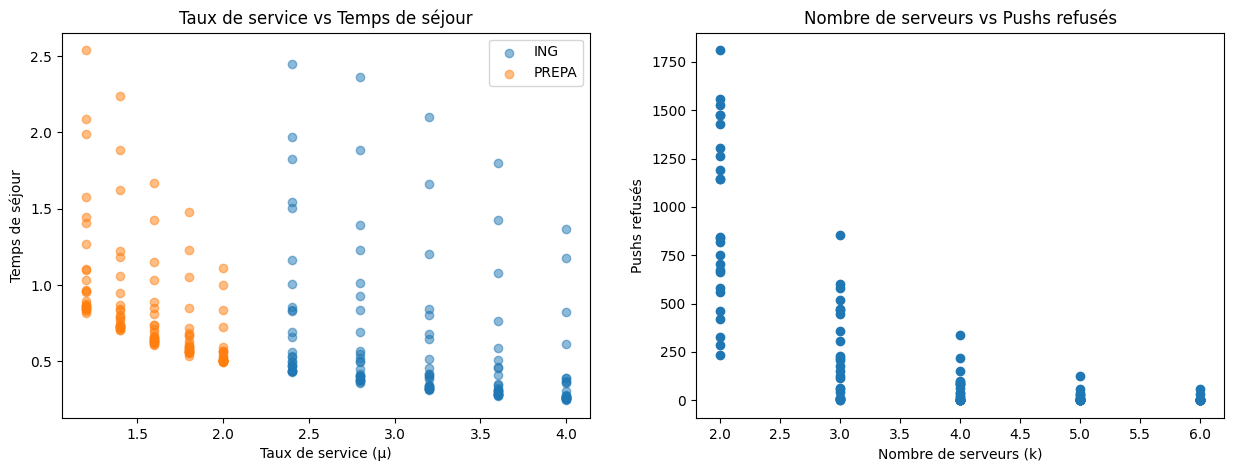

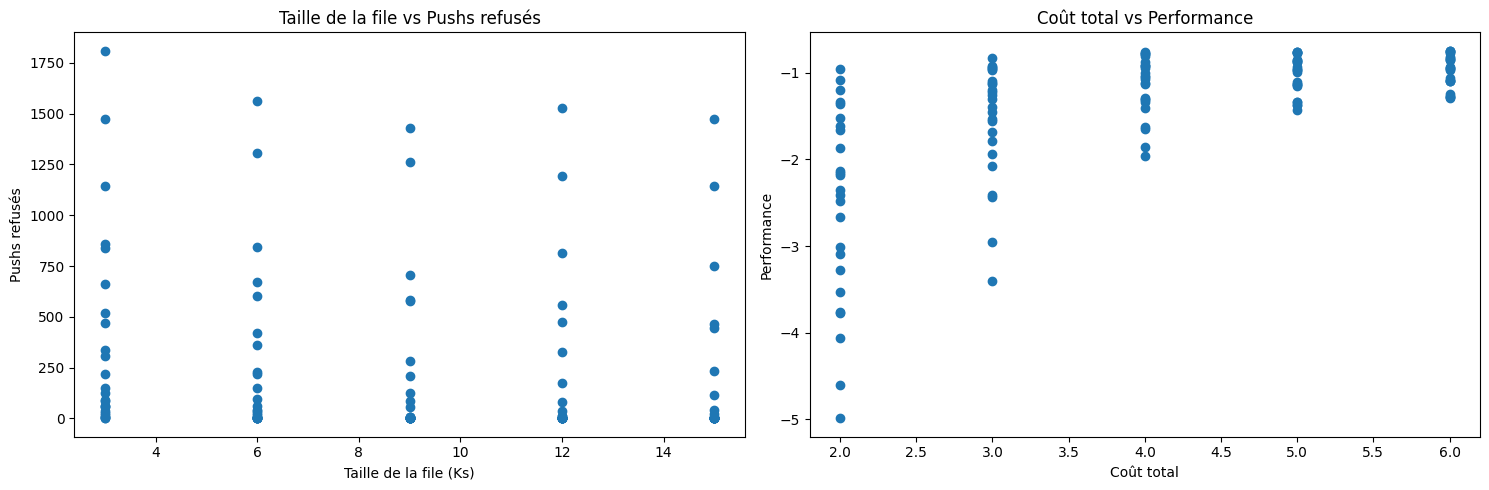

In [59]:
def optimize_parameters(base_lambda_ing, base_lambda_prepa, 
                       mu_ing_range, 
                       k_range, ks_range, 
                       test_z=5000):
    """
    Trouver les paramètres optimaux en testant différentes combinaisons.

    Args:
        base_lambda_ing/prepa: Taux d'arrivée fixe (supposé basé sur le système réel, analyses plus précises à venir)
        mu_ing_range: Plage de taux de service à tester
        k_range: Plage de nombres de serveurs à tester
        ks_range: Plage de tailles de file à tester  (SANS le nombre de serveurs)
        test_z: Nombre de simulations
    
    Retournes:
        DataFrame avec les résultats et les meilleures configurations
    """
    results = []
    gen = np.random.default_rng(seed=42)
    
    for k in k_range:
        for ks in ks_range:
            for mu_ing in mu_ing_range:
                mu_prepa = mu_ing * 0.5
                # Lance la simulation
                mmk_queue = mmk_finite_two_populations(
                    lamda_ing=base_lambda_ing,
                    lamda_prepa=base_lambda_prepa,
                    mu_ing=mu_ing,
                    mu_prepa=mu_prepa,
                    k=k,
                    Ks=ks,
                    gen=gen,
                    test_z=test_z
                )
                mmk_queue.run()
                stats = mmk_queue.stats()

                clear_output(wait=True)
                
                # Calculer les statistiques pour chaque population
                ing_stats = stats[stats['Population'] == 'ING'].iloc[0]
                prepa_stats = stats[stats['Population'] == 'PREPA'].iloc[0]
                
                # Calculer l'utilisation du serveur
                total_arrival_rate = base_lambda_ing + base_lambda_prepa
                avg_service_rate = (mu_ing + mu_prepa) / 2
                utilization = total_arrival_rate / (k * avg_service_rate)
                
                results.append({
                    'k': k,
                    'Ks': ks,
                    'mu_ing': mu_ing,
                    'mu_prepa': mu_prepa,
                    'ing_sojourn': ing_stats['Mean Sojourn Time'],
                    'prepa_sojourn': prepa_stats['Mean Sojourn Time'],
                    'ing_refused': ing_stats['Refused Pushes'],
                    'prepa_refused': prepa_stats['Refused Pushes'],
                    'utilization': utilization,
                    'total_cost': k  # Coût total (proportionnel au nombre de serveurs)
                })
    
    results_df = pd.DataFrame(results)
    
    # Trouver le score d'efficacité pour chaque configuration
    results_df['efficiency_score'] = (
        -results_df['ing_sojourn'] 
        - results_df['prepa_sojourn'] 
        - 0.1 * (results_df['ing_refused'] + results_df['prepa_refused'])
        - results_df['total_cost']
    )
    
    return results_df

# Recherche des paramètres optimaux
k_range = [2, 3, 4, 5, 6]
ks_range = [3, 6, 9, 12, 15]
mu_ing_range = [2.4, 2.8, 3.2, 3.6, 4.0]

optimization_results = optimize_parameters(
    base_lambda_ing=4,
    base_lambda_prepa=2,
    mu_ing_range=mu_ing_range,
    k_range=k_range,
    ks_range=ks_range
)

# Visualisation des résultats
plt.figure(figsize=(15, 5))

# Plot 1: Taux de service vs temps de séjour
plt.subplot(1, 2, 1)
plt.scatter(optimization_results['mu_ing'], 
           optimization_results['ing_sojourn'],
           alpha=0.5, label='ING')
plt.scatter(optimization_results['mu_prepa'], 
           optimization_results['prepa_sojourn'],
           alpha=0.5, label='PREPA')
plt.xlabel('Taux de service (μ)')
plt.ylabel('Temps de séjour')
plt.title('Taux de service vs Temps de séjour')
plt.legend()

# Plot 2: Nombre de serveurs vs pushs refusés
plt.subplot(1, 2, 2)
plt.scatter(optimization_results['k'], 
           optimization_results['ing_refused'] + optimization_results['prepa_refused'])
plt.xlabel('Nombre de serveurs (k)')
plt.ylabel('Pushs refusés')
plt.title('Nombre de serveurs vs Pushs refusés')

# Analyses additionnelles
plt.figure(figsize=(15, 5))

# Plot 3: Taille de la file vs pushs refusés
plt.subplot(1, 2, 1)
plt.scatter(optimization_results['Ks'], 
           optimization_results['ing_refused'] + optimization_results['prepa_refused'])
plt.xlabel('Taille de la file (Ks)')
plt.ylabel('Pushs refusés')
plt.title('Taille de la file vs Pushs refusés')

# Plot 4: Coût total vs performance
optimization_results['performance'] = -(optimization_results['ing_sojourn'] + optimization_results['prepa_sojourn'])
plt.subplot(1, 2, 2)
plt.scatter(optimization_results['total_cost'],
           optimization_results['performance'])
plt.xlabel('Coût total')
plt.ylabel('Performance')
plt.title('Coût total vs Performance')

plt.tight_layout()
plt.show()

Après observations des résultats, nous avons fait les choix suivants :
- K = 4 : A partir de cette valeure, on peut observer que le nombre de pushs refusés reste constament en dessous de 10% de la population totale. Cela semble être l'option la plus adaptée en terme de coût et de pushs refusés.
- μ ING = 3.2 et μ PREPA = 1.6 : on constate que le temps de séjour diminue significativement à partir de μ PREPA = 1.6. Il n'est pas nécessaire de choisir une valeure plus élevée, car plus ces valeures sont hautes, plus elles metterons la file M/M/1 en difficulté par la suite.
- Ks = 6 : bien que ce paramètre soit clé pour la file M/M/1, il est moins important ici. On observe que le nombre de pushs refusé est similaire pour les différentes valeures de Ks, tant que celle-ci n'est pas trop basse (<4). Nous avons donc gardé une valeure raisonnable, 6.

Nous pouvons maintenant analyser la file M/M/1 en fonction de ces paramètres. Pour trouver une valeure de mu qui restera stable même dans des conditions complexes, nous prendrons des taux d'arrivée (λ ING et λ PREPA) légèrement élevées (6 et 3).

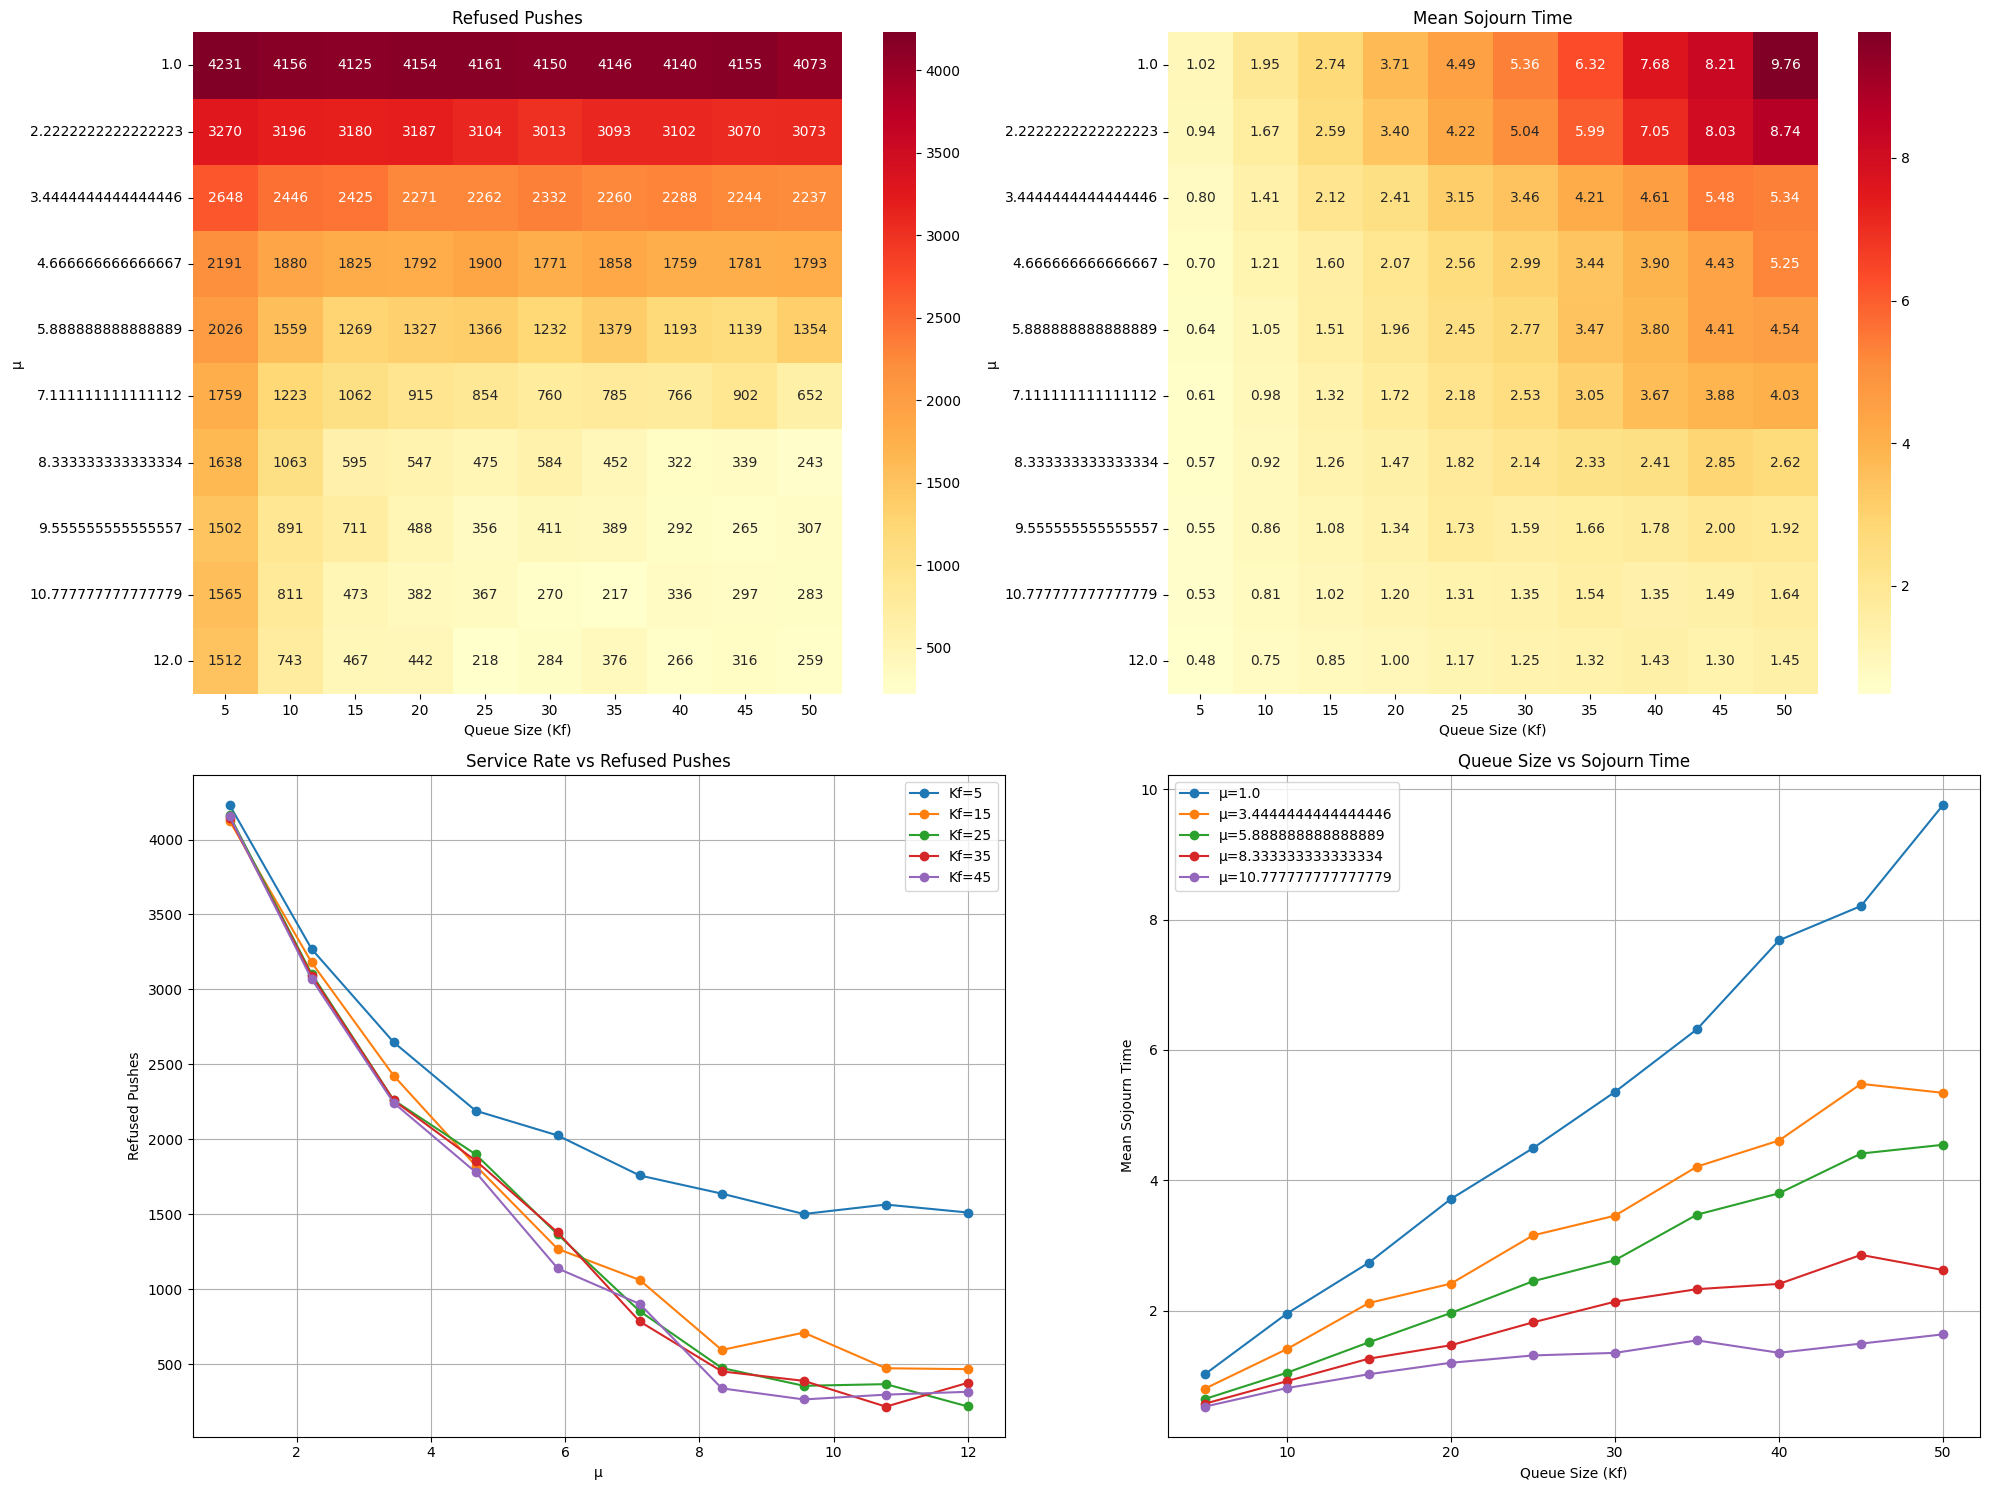

In [65]:
def benchmark_mm1_parameters(lambda_arr=1.0, 
                           mu_range=np.linspace(1, 12, 10),
                           kf_range=range(5, 51, 5),
                           test_z=5000):
    """
    Benchmark de la file MM1 avec une M/M/K contenant nos deux populations.
    """
    results = []
    gen = np.random.default_rng(seed=42)
    
    for mu in mu_range:
        for kf in kf_range:
            # Creation de la file M/M/K
            mmk_queue = mmk_finite_two_populations(
                lamda_ing=6.0,
                lamda_prepa=3.0,
                mu_ing=3.2, 
                mu_prepa=1.6, 
                k=4,
                Ks=6, 
                gen=gen, 
                test_z=test_z
            )
            mmk_queue.run()

            clear_output(wait=True)
            
            prev_tops = pd.DataFrame(
                index=range(test_z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((test_z, 3))
            )
            prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]
            
            # Lancement de la file M/M/1
            mm1_queue = mm1_finite(
                lamda=lambda_arr,
                mu=mu,
                gen=gen,
                Kf=kf,
                test_z=test_z,
                previous_tops=prev_tops
            )
            mm1_queue.run()

            clear_output(wait=True)
            
            stats, _ = mm1_queue.stats()
            
            results.append({
                'mu': mu,
                'Kf': kf,
                'mean_sojourn': stats.loc['mean_sojourn_time', 'value'],
                'mean_waiting': stats.loc['mean_waiting_time', 'value'],
                'mean_service': stats.loc['mean_service_time', 'value'],
                'refused_pushes': stats.loc['refused_pushes', 'value'],
                'utilization': lambda_arr / mu
            })
            
    return pd.DataFrame(results)

# Lancement du benchmark
results = benchmark_mm1_parameters()

# Création des visualisations
plt.figure(figsize=(20, 15))

# Plot 1: Heatmap des pushs refusés
plt.subplot(2, 2, 1)
pivot_refused = results.pivot_table(
    values='refused_pushes',
    index='mu',
    columns='Kf'
)
sns.heatmap(pivot_refused, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Refused Pushes')
plt.xlabel('Queue Size (Kf)')
plt.ylabel('μ')

# Plot 2: Heatmap des temps de séjour
plt.subplot(2, 2, 2)
pivot_sojourn = results.pivot_table(
    values='mean_sojourn',
    index='mu',
    columns='Kf'
)
sns.heatmap(pivot_sojourn, cmap='YlOrRd', annot=True, fmt='.2f')
plt.title('Mean Sojourn Time')
plt.xlabel('Queue Size (Kf)')
plt.ylabel('μ')

# Plot 3: Taux de service vs pushs refusés
plt.subplot(2, 2, 3)
for kf in results['Kf'].unique()[::2]:
    data = results[results['Kf'] == kf]
    plt.plot(data['mu'], data['refused_pushes'], 
             marker='o', label=f'Kf={kf}')
plt.xlabel('μ')
plt.ylabel('Refused Pushes')
plt.title('Service Rate vs Refused Pushes')
plt.legend()
plt.grid(True)

# Plot 4: Taille de la file vs temps de séjour
plt.subplot(2, 2, 4)
for mu in results['mu'].unique()[::2]:
    data = results[results['mu'] == mu]
    plt.plot(data['Kf'], data['mean_sojourn'], 
             marker='o', label=f'μ={mu}')
plt.xlabel('Queue Size (Kf)')
plt.ylabel('Mean Sojourn Time')
plt.title('Queue Size vs Sojourn Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Concernant le paramètre mu, on constate une augmentation significative du nombre de push rejeté avant : mu=3.5. Passé cette valeure, les résultats s'améliore proportionellement à l'augmentation de mu. Pour la suite de notre simulation, nous garderons mu=8 pour être confortables si la file reçoit nombre inhabituel d'arrivées.

Ensuite, la valeure de Kf ne peut pas être inférieure ou égale à 5 sans provoquer un grand nombre de rejet de push. De plus, à partir de Kf=40, on observe un temps de séjour trop important. Pour la suite, nous garderons donc Kf=35.

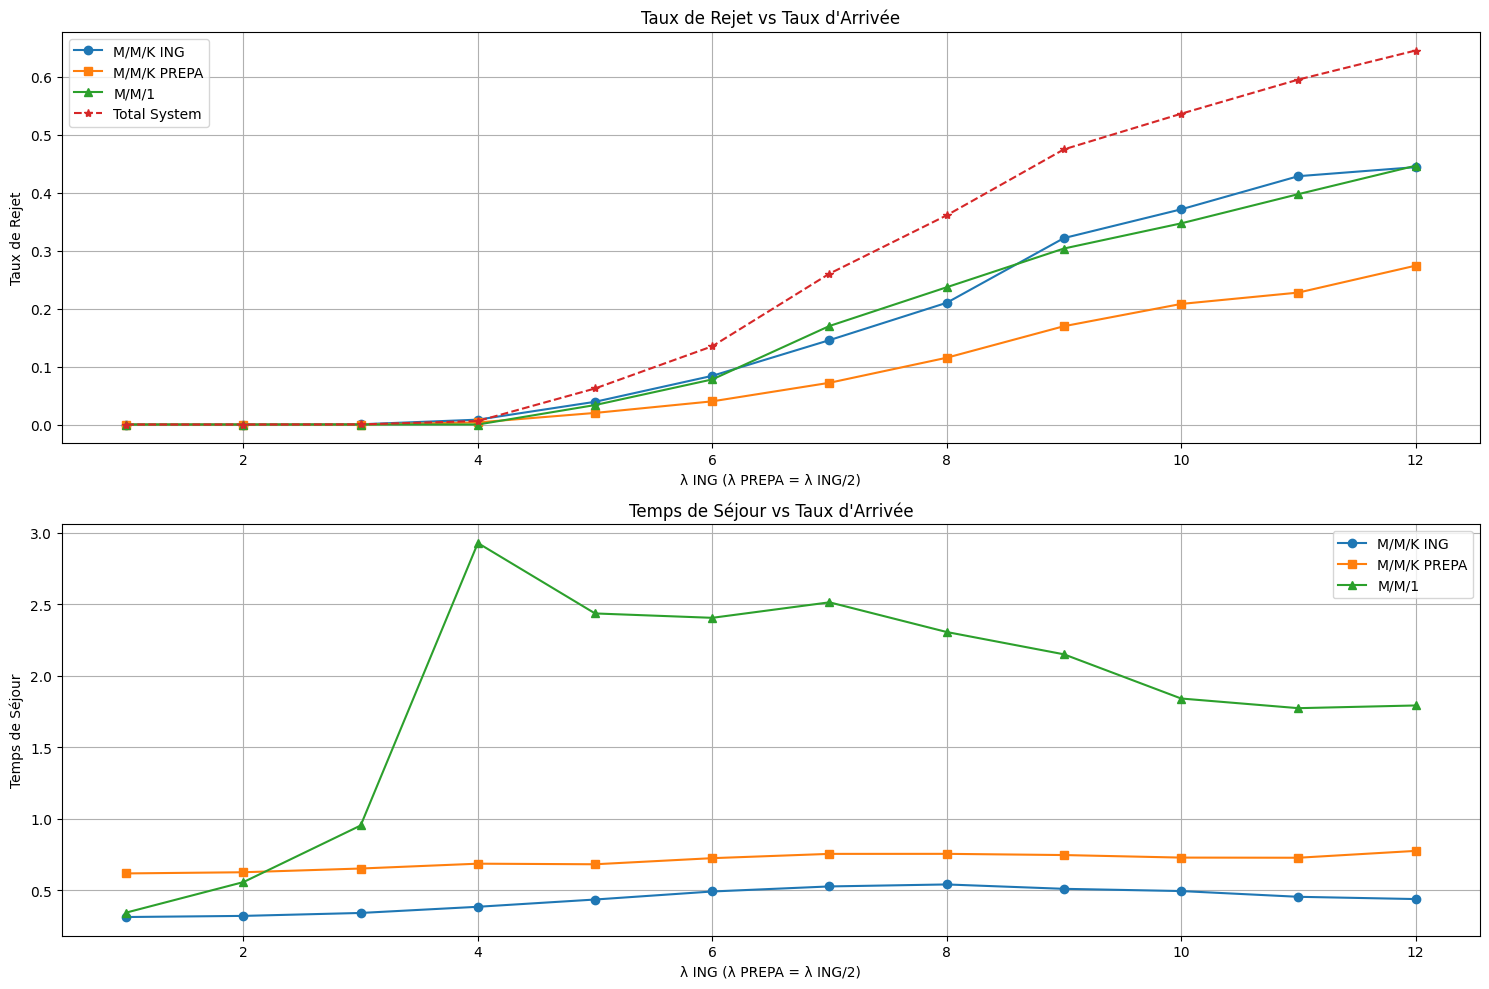

In [71]:
def benchmark_system_lambda_scaling(base_mu_prepa=1.6, 
                                  k=4, ks=6, kf=35, 
                                  mm1_mu=8, test_z=5000):
    """
    Benchmark des taux d'arrivée
    """
    lambda_prepa_range = np.linspace(0.5, 6.0, 12)
    
    results = []
    gen = np.random.default_rng(seed=42)
    
    for lambda_prepa in lambda_prepa_range:
        lambda_ing = 2 * lambda_prepa
        
        # M/M/K
        mmk_queue = mmk_finite_two_populations(
            lamda_ing=lambda_ing,
            lamda_prepa=lambda_prepa,
            mu_ing=base_mu_prepa*2,
            mu_prepa=base_mu_prepa,
            k=k,
            Ks=ks,
            gen=gen,
            test_z=test_z
        )
        mmk_queue.run()
        mmk_stats = mmk_queue.stats()

        clear_output(wait=True)
        
        # Préparation des données pour M/M/1
        prev_tops = pd.DataFrame(
            index=range(test_z),
            columns=['t_arrival', 't_service_start', 't_departure'],
            data=np.zeros((test_z, 3))
        )
        prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]
        
        # Calcule de l'efficacité de lambda pour M/M/1
        accepted_pushes_mmk = test_z - (mmk_stats['Refused Pushes'].sum())
        effective_lambda_mm1 = accepted_pushes_mmk / mmk_queue.tops["t_departure"].max()
        
        # M/M/1
        mm1_queue = mm1_finite(
            lamda=effective_lambda_mm1,
            mu=mm1_mu,
            gen=gen,
            Kf=kf,
            test_z=test_z,
            previous_tops=prev_tops
        )
        mm1_queue.run()
        mm1_stats, _ = mm1_queue.stats()

        clear_output(wait=True)
        
        # Calcul des statistiques pour chaque population
        ing_stats = mmk_stats[mmk_stats['Population'] == 'ING'].iloc[0]
        prepa_stats = mmk_stats[mmk_stats['Population'] == 'PREPA'].iloc[0]
        
        results.append({
            'lambda_ing': lambda_ing,
            'lambda_prepa': lambda_prepa,
            'mmk_rejection_rate_ing': ing_stats['Refused Pushes'] / (test_z/2),
            'mmk_rejection_rate_prepa': prepa_stats['Refused Pushes'] / (test_z/2),
            'mmk_sojourn_time_ing': ing_stats['Mean Sojourn Time'],
            'mmk_sojourn_time_prepa': prepa_stats['Mean Sojourn Time'],
            'effective_lambda_mm1': effective_lambda_mm1,
            'mm1_rejection_rate': mm1_stats.loc['refused_pushes', 'value'] / test_z,
            'mm1_sojourn_time': mm1_stats.loc['mean_sojourn_time', 'value'],
            'total_rejection_rate': 1 - (
                (1 - mm1_stats.loc['refused_pushes', 'value'] / test_z) * 
                (1 - (ing_stats['Refused Pushes'] + prepa_stats['Refused Pushes']) / test_z)
            )
        })
    
    return pd.DataFrame(results)

# Lancement du benchmark
results = benchmark_system_lambda_scaling()

# Création des visualisations
plt.figure(figsize=(15, 10))

# Plot 1: Taux de rejet
plt.subplot(211)
plt.plot(results['lambda_ing'], results['mmk_rejection_rate_ing'], 
         marker='o', label='M/M/K ING')
plt.plot(results['lambda_ing'], results['mmk_rejection_rate_prepa'], 
         marker='s', label='M/M/K PREPA')
plt.plot(results['lambda_ing'], results['mm1_rejection_rate'], 
         marker='^', label='M/M/1')
plt.plot(results['lambda_ing'], results['total_rejection_rate'], 
         marker='*', label='Total System', linestyle='--')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Taux de Rejet')
plt.title('Taux de Rejet vs Taux d\'Arrivée')
plt.legend()
plt.grid(True)

# Plot 2: Temps de séjour
plt.subplot(212)
plt.plot(results['lambda_ing'], results['mmk_sojourn_time_ing'], 
         marker='o', label='M/M/K ING')
plt.plot(results['lambda_ing'], results['mmk_sojourn_time_prepa'], 
         marker='s', label='M/M/K PREPA')
plt.plot(results['lambda_ing'], results['mm1_sojourn_time'], 
         marker='^', label='M/M/1')
plt.xlabel('λ ING (λ PREPA = λ ING/2)')
plt.ylabel('Temps de Séjour')
plt.title('Temps de Séjour vs Taux d\'Arrivée')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

On constate que nos files ont un comportement similaire au niveau des taux de rejet lors de l'augmentation du taux d'arrivée. Elles gardent un taux de rejet acceptable (<10%) jusqu'à lambda_ing=6.
Au niveau des temps de séjour, on constate que la file M/M/K est stable sur les valeures testées, mais que la file M/M/1 est en difficulté à partir de lambda_ing=4.

Pour une utilisation stable de notre simulation, nous choisirons donc
- lambda ING=4 et lambda PREPA=2.

La simulation finale serait donc :

Lancement de la simulation M/M/K pour deux populations


/tmp/ipykernel_1430/825909133.py:81: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'PREPA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  self.tops.loc[i, "population"] = population


Lancement de la simulation de la file M/M/1 avec une capacité finie

Statistiques de la file M/M/K:
  Population  Mean Waiting Time  Mean Service Time  Mean Sojourn Time  \
0        ING           0.079156           0.308907           0.388063   
1      PREPA           0.041292           0.616993           0.658285   

   Refused Pushes  
0              24  
1               8  

Statistiques de la file M/M/1:
(                      value
mean_sojourn_time  3.806943
mean_waiting_time  3.680085
mean_service_time  0.126858
refused_pushes     1.000000,       Arrival Time  Departure Time
0         0.271541        0.292207
1         0.718853        0.722648
2         2.119920        2.214457
3         1.662337        2.325232
4         2.318165        2.670508
...            ...             ...
4995   1194.631084     1194.776876
4996   1194.127381     1194.823465
4997   1194.010597     1194.877377
4998   1193.211085     1194.894357
4999   1194.027799     1195.015705

[5000 rows x 2 columns])


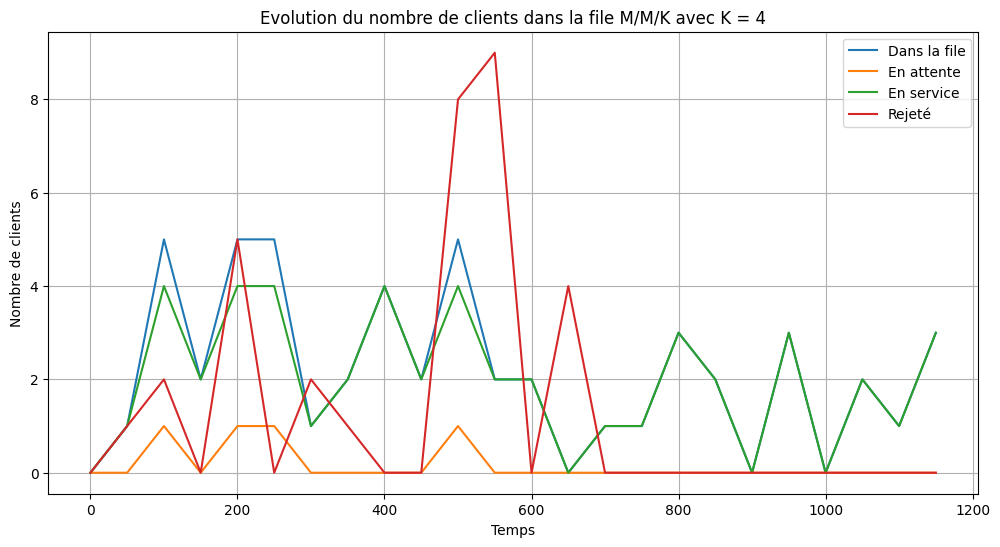

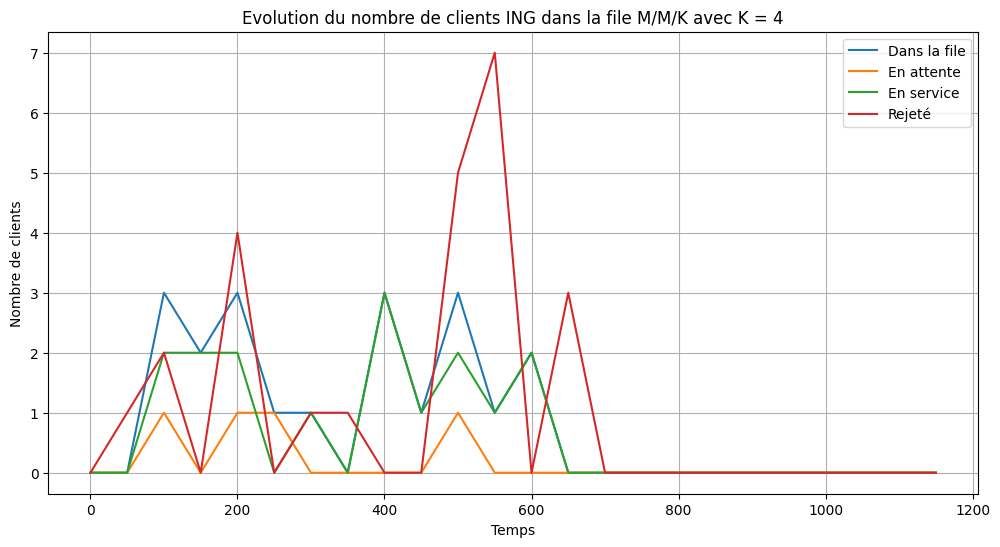

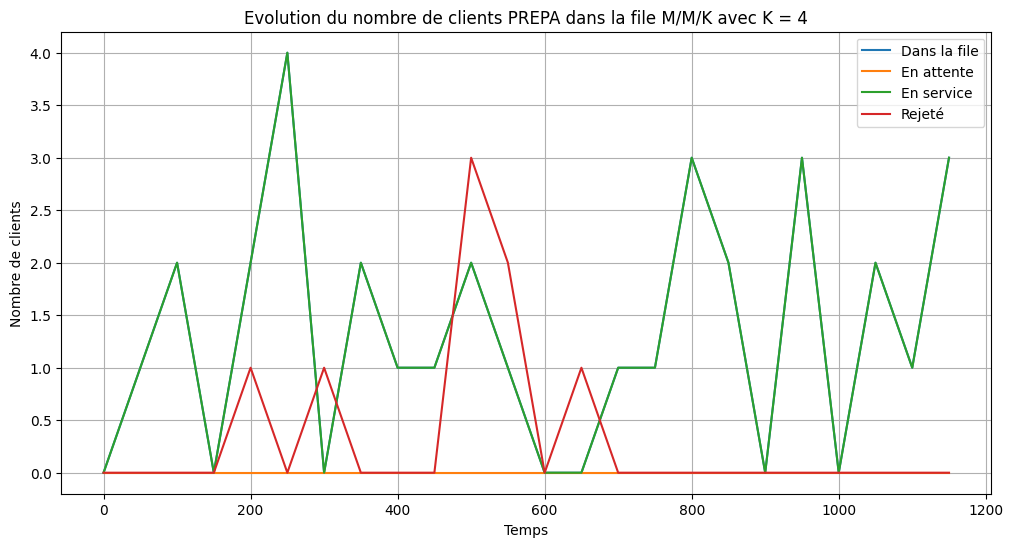

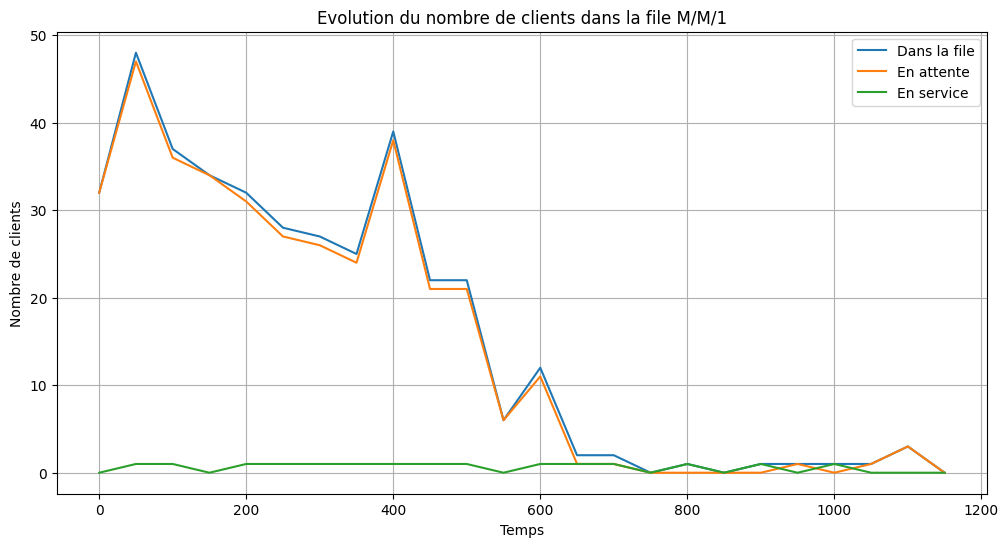

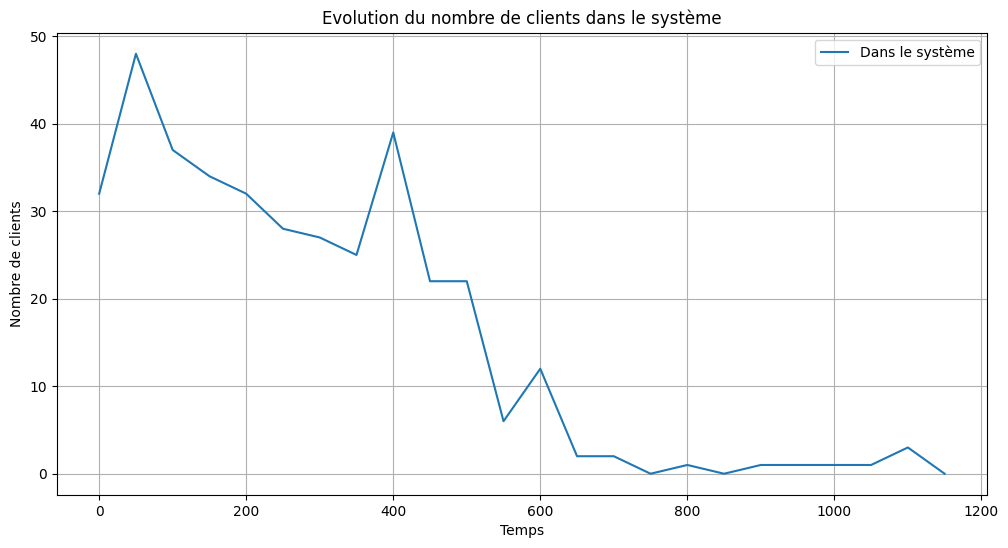

In [69]:
# Paramètres de la file M/M/K
lambda_arr_ing = 4  # Taux d'arrivée des pushs population ing
lambda_arr_prepa = 2 # Taux d'arrivée des pushs population prepa
mu_1_ing = 3.2 # Taux de service des serveurs population ing
mu_1_prepa = 1.6 # Taux de service des serveurs population prepa
K = 4            # Nombre de serveurs
gen = np.random.default_rng(seed=42)
z = 5000
Ks = 6 # Taille maximale de la file pour M/M/K (SANS le nombre de serveurs)

# Paramètres de la file M/M/1
lambda_arr_2 = 1  # Taux d'arrivée des pushs
mu_2 = 8       # Taux de service du serveur
Kf = 35 # Taille maximale de la file pour M/M/1 (SANS le nombre de serveurs)

# Créer une instance de la file M/M/K
mmk_queue = mmk_finite_two_populations(lamda_ing=lambda_arr_ing, lamda_prepa=lambda_arr_prepa,mu_ing=mu_1_ing, mu_prepa=mu_1_prepa, k=K, Ks=Ks, gen=gen, test_z=z)

# Simuler la file d'attente
mmk_queue.run()

prev_tops = pd.DataFrame(
                index=range(z),
                columns=['t_arrival', 't_service_start', 't_departure'],
                data=np.zeros((z, 3))
            )
prev_tops["t_arrival"] = mmk_queue.tops["t_departure"]

# Créer une instance de la file M/M/1
mm1_queue = mm1_finite(lamda=lambda_arr_2, mu=mu_2, gen=gen, Kf=Kf, test_z=z, previous_tops=prev_tops)

# Simuler la file d'attente
mm1_queue.run()

# Afficher les statistiques
print("\nStatistiques de la file M/M/K:")
print(mmk_queue.stats())

print("\nStatistiques de la file M/M/1:")
print(mm1_queue.stats())

# Calculer les comptages à intervalles réguliers pour la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50,)

# Tracer l'évolution du nombre de clients dans la file M/M/K
plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.plot(counts_df_k.index, counts_df_k['rejected'], label='Rejeté')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients ing dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="ING")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.plot(counts_df_k.index, counts_df_k['rejected'], label='Rejeté')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients ING dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients prepa dans la file M/M/K
counts_df_k = mmk_queue.counts(t_intervals=50, population="PREPA")

plt.figure(figsize=(12, 6))
plt.plot(counts_df_k.index, counts_df_k['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_k.index, counts_df_k['ag_in_queue'], label='En attente')
plt.plot(counts_df_k.index, counts_df_k['ag_in_service'], label='En service')
plt.plot(counts_df_k.index, counts_df_k['rejected'], label='Rejeté')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients PREPA dans la file M/M/K avec K = ' + str(K))
plt.legend()
plt.grid(True)
plt.show()

# Calculer les comptages à intervalles réguliers pour la file M/M/1
counts_df_1 = mm1_queue.counts(t_intervals=50)

# Tracer l'évolution du nombre de clients dans la file M/M/1
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans la file')
plt.plot(counts_df_1.index, counts_df_1['ag_in_queue'], label='En attente')
plt.plot(counts_df_1.index, counts_df_1['ag_in_service'], label='En service')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans la file M/M/1')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'évolution du nombre de clients dans le système
plt.figure(figsize=(12, 6))
plt.plot(counts_df_1.index, counts_df_1['ag_in_sys'], label='Dans le système')
plt.xlabel('Temps')
plt.ylabel('Nombre de clients')
plt.title('Evolution du nombre de clients dans le système')
plt.legend()
plt.grid(True)
plt.show()

On constate une quantité de refus raisonnable, et une évolution stable du système dans le temps.